In [2]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = ConcatDataset([datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)])

# Calculating mean and standard deviation for this dataset
mean = torch.zeros(3)
std = torch.zeros(3)
for img, _ in dataset:
  mean += img.mean([1,2])
  std += img.std([1,2])
mean /= len(dataset)
std /= len(dataset)

print(f"Mean: {mean}")
print(f"Standart Deviation: {std}")

# Reinitializing the dataset with normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean.tolist(), std=std.tolist())])
dataset = ConcatDataset([datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)])

100%|██████████| 170498071/170498071 [00:05<00:00, 28438275.77it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Mean: tensor([0.4914, 0.4822, 0.4465])
Standart Deviation: tensor([0.2023, 0.1994, 0.2010])


In [4]:
total_size = len(dataset)
train_size = int(total_size * 0.8)
test_size = int(total_size * 0.1)
val_size = total_size - train_size - test_size

trainset, testset, valset = random_split(dataset, [train_size, test_size, val_size])

batch_size = 2**7
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # to ensure that the model remains general and does not overfit to the specific sequence of data
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)

In [5]:
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # First Convolutional Layer (Input: 32x32x3, Output: 32x32x8)
            nn.Conv2d(3, 8, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # First Max Pooling (Output: 16x16x8)

            # Second Convolutional Layer (Output: 16x16x12)
            nn.Conv2d(8, 12, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Second Max Pooling (Output: 8x8x12)

            # Third Convolutional Layer (Output: 8x8x16)
            nn.Conv2d(12, 16, 3, stride=1, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            # First Upsampling (Input: 8x8x16, Output: 16x16x16)
            nn.ConvTranspose2d(16, 12, 2, stride=2),
            nn.ReLU(),

            # Fourth Convolutional Layer (Output: 16x16x12)
            nn.Conv2d(12, 12, 3, stride=1, padding=1),
            nn.ReLU(),

            # Second Upsampling (Output: 32x32x12)
            nn.ConvTranspose2d(12, 8, 2, stride=2),
            nn.ReLU(),

            # Fifth Convolutional Layer (Output: 32x32x3)
            nn.Conv2d(8, 3, 3, stride=1, padding=1),
            # nn.Sigmoid()  or nn.Tanh() # but the input images are not normalized between 0(-1) and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
# Initializing the model
model = ConvAutoencoder()

criterion = nn.MSELoss() # Loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    model = model.cuda()

In [7]:
num_epochs = 15
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}')

    # Validation
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, _ in val_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item()

        validation_loss /= len(val_loader)
        val_losses.append(validation_loss)
        print(f'Validation Loss after epoch {epoch+1}: {validation_loss:.4f}')

Epoch [1/15], Training Loss: 0.5942
Validation Loss after epoch 1: 0.3230
Epoch [2/15], Training Loss: 0.2953
Validation Loss after epoch 2: 0.2753
Epoch [3/15], Training Loss: 0.2659
Validation Loss after epoch 3: 0.2555
Epoch [4/15], Training Loss: 0.2208
Validation Loss after epoch 4: 0.1830
Epoch [5/15], Training Loss: 0.1749
Validation Loss after epoch 5: 0.1657
Epoch [6/15], Training Loss: 0.1621
Validation Loss after epoch 6: 0.1561
Epoch [7/15], Training Loss: 0.1544
Validation Loss after epoch 7: 0.1507
Epoch [8/15], Training Loss: 0.1488
Validation Loss after epoch 8: 0.1444
Epoch [9/15], Training Loss: 0.1433
Validation Loss after epoch 9: 0.1397
Epoch [10/15], Training Loss: 0.1379
Validation Loss after epoch 10: 0.1344
Epoch [11/15], Training Loss: 0.1324
Validation Loss after epoch 11: 0.1284
Epoch [12/15], Training Loss: 0.1275
Validation Loss after epoch 12: 0.1248
Epoch [13/15], Training Loss: 0.1238
Validation Loss after epoch 13: 0.1214
Epoch [14/15], Training Loss: 

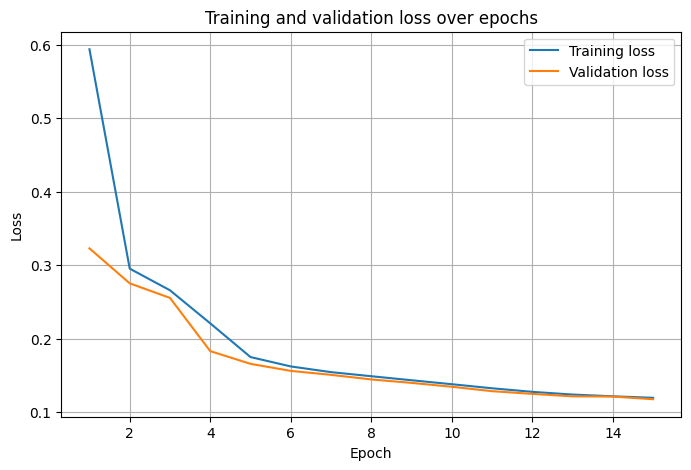

In [11]:
import matplotlib.pyplot as plt

epochs = range(1, 16)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, val_losses, label='Validation loss')
plt.title('Training and validation loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, _ in test_loader:
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.1175


In [13]:
# Exercise 2(a)

LSR_volume = 16
LSR_kernel = 3
LSR_padding = 1
LSR_stride = 1
LSR_channels = 16

LSR_size = LSR_channels * ((LSR_volume - LSR_kernel + 2 * LSR_padding) / LSR_stride + 1) ** 2
print(f'Size of Latent Space Representation is {int(LSR_size)}')

Size of Latent Space Representation is 4096


Exercise 2(b)

Fewer number of layers most probably will simplify the model and make it less capable of capturing complex patterns in the data, what could lead to higher reconstruction errors. Additional layers will increase the model's capacity to learn features but it requires more training time and also the risks of overfitting is much higher. Let's try previous model without the third convolutional layer from the encoder and adjust the corresponding layer in the decoder.





In [14]:
class ConvAutoencoder2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # First Convolutional Layer (Input: 32x32x3, Output: 32x32x8)
            nn.Conv2d(3, 8, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # First Max Pooling (Output: 16x16x8)

            # Second Convolutional Layer (Output: 16x16x12)
            nn.Conv2d(8, 12, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Second Max Pooling (Output: 8x8x12)

        )

        # Decoder
        self.decoder = nn.Sequential(
            # First Upsampling (Input: 8x8x12, Output: 16x16x12)
            nn.ConvTranspose2d(12, 8, 2, stride=2),
            nn.ReLU(),

            # Second Upsampling (Output: 32x32x8)
            nn.ConvTranspose2d(8, 3, 2, stride=2),
            nn.ReLU(),

            # Adjusted Fifth Convolutional Layer (Output: 32x32x3)
            nn.Conv2d(3, 3, 3, stride=1, padding=1),
            # nn.Sigmoid()  or nn.Tanh() # depending on normalization
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
# Initializing the model
model2 = ConvAutoencoder2()

criterion = nn.MSELoss() # Loss function

optimizer = optim.Adam(model2.parameters(), lr=0.001)

if torch.cuda.is_available():
    model2 = model2.cuda()

In [18]:
num_epochs = 15
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model2.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        optimizer.zero_grad()

        # Forward pass
        outputs = model2(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}')

    # Validation
    model2.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, _ in val_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()

            outputs = model2(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item()

        validation_loss /= len(val_loader)
        val_losses.append(validation_loss)
        print(f'Validation Loss after epoch {epoch+1}: {validation_loss:.4f}')

Epoch [1/15], Training Loss: 0.5445
Validation Loss after epoch 1: 0.3002
Epoch [2/15], Training Loss: 0.2386
Validation Loss after epoch 2: 0.2009
Epoch [3/15], Training Loss: 0.1834
Validation Loss after epoch 3: 0.1708
Epoch [4/15], Training Loss: 0.1657
Validation Loss after epoch 4: 0.1606
Epoch [5/15], Training Loss: 0.1583
Validation Loss after epoch 5: 0.1549
Epoch [6/15], Training Loss: 0.1537
Validation Loss after epoch 6: 0.1514
Epoch [7/15], Training Loss: 0.1501
Validation Loss after epoch 7: 0.1478
Epoch [8/15], Training Loss: 0.1465
Validation Loss after epoch 8: 0.1437
Epoch [9/15], Training Loss: 0.1414
Validation Loss after epoch 9: 0.1378
Epoch [10/15], Training Loss: 0.1360
Validation Loss after epoch 10: 0.1337
Epoch [11/15], Training Loss: 0.1325
Validation Loss after epoch 11: 0.1308
Epoch [12/15], Training Loss: 0.1301
Validation Loss after epoch 12: 0.1287
Epoch [13/15], Training Loss: 0.1282
Validation Loss after epoch 13: 0.1271
Epoch [14/15], Training Loss: 

In [19]:
model2.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, _ in test_loader:
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        outputs = model2(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.1242


The increase in test loss in the simplified model (without the third convolutional layer) indicates that the removed layer contributed to the model's ability to capture and reconstruct the important features of the input data.

Now let's check what happens if we change the filter size (padding is adjusted to 2)

In [20]:
import torch.nn as nn

class ConvAutoencoder3(nn.Module):
    def __init__(self):
        super(ConvAutoencoder3, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # First Convolutional Layer with 5x5 filters (Input: 32x32x3, Output: 32x32x8)
            nn.Conv2d(3, 8, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # First Max Pooling (Output: 16x16x8)

            # Second Convolutional Layer with 5x5 filters (Output: 16x16x12)
            nn.Conv2d(8, 12, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Second Max Pooling (Output: 8x8x12)

            # Third Convolutional Layer with 5x5 filters (Output: 8x8x16)
            nn.Conv2d(12, 16, 5, stride=1, padding=2),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            # First Upsampling (Input: 8x8x16, Output: 16x16x16)
            nn.ConvTranspose2d(16, 12, 2, stride=2),
            nn.ReLU(),

            # Fourth Convolutional Layer with 5x5 filters (Output: 16x16x12)
            nn.Conv2d(12, 12, 5, stride=1, padding=2),
            nn.ReLU(),

            # Second Upsampling (Output: 32x32x12)
            nn.ConvTranspose2d(12, 8, 2, stride=2),
            nn.ReLU(),

            # Fifth Convolutional Layer with 5x5 filters (Output: 32x32x3)
            nn.Conv2d(8, 3, 5, stride=1, padding=2),
            nn.Sigmoid()  # If the input images are normalized between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
# Initializing the model
model3 = ConvAutoencoder2()

criterion = nn.MSELoss() # Loss function

optimizer = optim.Adam(model3.parameters(), lr=0.001)

if torch.cuda.is_available():
    model3 = model3.cuda()

In [22]:
num_epochs = 15
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model3.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        optimizer.zero_grad()

        # Forward pass
        outputs = model3(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}')

    # Validation
    model3.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, _ in val_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()

            outputs = model3(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item()

        validation_loss /= len(val_loader)
        val_losses.append(validation_loss)
        print(f'Validation Loss after epoch {epoch+1}: {validation_loss:.4f}')

Epoch [1/15], Training Loss: 0.6079
Validation Loss after epoch 1: 0.3188
Epoch [2/15], Training Loss: 0.2860
Validation Loss after epoch 2: 0.2142
Epoch [3/15], Training Loss: 0.1834
Validation Loss after epoch 3: 0.1683
Epoch [4/15], Training Loss: 0.1632
Validation Loss after epoch 4: 0.1576
Epoch [5/15], Training Loss: 0.1549
Validation Loss after epoch 5: 0.1512
Epoch [6/15], Training Loss: 0.1500
Validation Loss after epoch 6: 0.1477
Epoch [7/15], Training Loss: 0.1467
Validation Loss after epoch 7: 0.1446
Epoch [8/15], Training Loss: 0.1436
Validation Loss after epoch 8: 0.1415
Epoch [9/15], Training Loss: 0.1401
Validation Loss after epoch 9: 0.1381
Epoch [10/15], Training Loss: 0.1358
Validation Loss after epoch 10: 0.1331
Epoch [11/15], Training Loss: 0.1308
Validation Loss after epoch 11: 0.1282
Epoch [12/15], Training Loss: 0.1268
Validation Loss after epoch 12: 0.1260
Epoch [13/15], Training Loss: 0.1244
Validation Loss after epoch 13: 0.1232
Epoch [14/15], Training Loss: 

In [23]:
model3.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, _ in test_loader:
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        outputs = model3(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.1200


Since CIFAR-10 contains small, 32x32 pixel images, where each pixel's information can be crucial, we lost some information by increasing the filter size.